In [1]:
import numpy as np
import pandas as pd
import re
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, recall_score, classification_report,confusion_matrix
import glob
import os
import matplotlib.pyplot as plt

In [2]:
train_path = max(glob.glob('./data/train/*.csv'), key=os.path.getctime) 
test_path = max(glob.glob('./data/test/*.csv'), key=os.path.getctime) 
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape)
print(test_df.shape)

(24756, 579)
(4369, 579)


In [3]:
print(train_df.columns.tolist())
# print(test_df.columns[:40])
# test_df.columns == train_df.columns

['reward_tiers', 'min_reward', 'max_reward', 'goal', 'state', 'staff_pick', 'has_video', 'rewards_0', 'rewards_1', 'rewards_2', 'rewards_3', 'rewards_4', 'rewards_5', 'rewards_6', 'rewards_7', 'rewards_8', 'rewards_9', 'rewards_10', 'rewards_11', 'rewards_12', 'rewards_13', 'rewards_14', 'rewards_15', 'rewards_16', 'rewards_17', 'rewards_18', 'rewards_19', 'rewards_20', 'rewards_21', 'rewards_22', 'rewards_23', 'rewards_24', 'rewards_25', 'rewards_26', 'rewards_27', 'rewards_28', 'rewards_29', 'rewards_30', 'rewards_31', 'rewards_32', 'rewards_33', 'rewards_34', 'rewards_35', 'rewards_36', 'rewards_37', 'rewards_38', 'rewards_39', 'rewards_40', 'rewards_41', 'rewards_42', 'rewards_43', 'rewards_44', 'rewards_45', 'rewards_46', 'rewards_47', 'rewards_48', 'rewards_49', 'rewards_50', 'rewards_51', 'rewards_52', 'rewards_53', 'rewards_54', 'rewards_55', 'rewards_56', 'rewards_57', 'rewards_58', 'rewards_59', 'rewards_60', 'rewards_61', 'rewards_62', 'rewards_63', 'rewards_64', 'rewards_65

In [6]:
# features_to_drop = ['rewards', 'deadline', 'launched_at', 'rewards_processed', 'created_at',
# 'description_processed', 'description_story_processed','description_risks_processed',
# 'id', 'name', 'description', 'description_story', 'description_risks', 'video', 'state',
# 'location', 'category']

#features that are dependent on time and the final outcome

X_train, y_train = train_df.drop('state', axis=1), train_df['state']
X_test, y_test = test_df.drop('state', axis=1), test_df['state']

In [7]:
# Combine train and test data set tgt

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [8]:
# Check if dataset is balanced
print(train_df[train_df.state == 1].shape)
print(train_df[train_df.state == 0].shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17482, 579)
(7274, 579)
(24756, 578)
(24756,)
(4369, 578)
(4369,)


In [9]:
#Default model
model_xgboost_default = XGBClassifier()

model_xgboost_default.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=[(X_test, y_test)],
                  verbose=True)

xgb_train_default_predict = model_xgboost_default.predict(X_train)
xgb_test_default_predict = model_xgboost_default.predict(X_test)

c:\Users\bandy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.51529
[1]	validation_0-logloss:0.41470
[2]	validation_0-logloss:0.34874
[3]	validation_0-logloss:0.30429
[4]	validation_0-logloss:0.27352
[5]	validation_0-logloss:0.25144
[6]	validation_0-logloss:0.23480
[7]	validation_0-logloss:0.22210
[8]	validation_0-logloss:0.21294
[9]	validation_0-logloss:0.20595
[10]	validation_0-logloss:0.19899
[11]	validation_0-logloss:0.19367
[12]	validation_0-logloss:0.18984
[13]	validation_0-logloss:0.18694
[14]	validation_0-logloss:0.18262
[15]	validation_0-logloss:0.18110
[16]	validation_0-logloss:0.17962
[17]	validation_0-logloss:0.17764
[18]	validation_0-logloss:0.17648
[19]	validation_0-logloss:0.17516
[20]	validation_0-logloss:0.17425
[21]	validation_0-logloss:0.17276
[22]	validation_0-logloss:0.17260
[23]	validation_0-logloss:0.17142
[24]	validation_0-logloss:0.17056
[25]	validation_0-logloss:0.16955
[26]	validation_0-logloss:0.16865
[27]	validation_0-logloss:0.16893
[28]	validation_0-logloss:0.16891
[29]	validation_0-loglos

**Evaluate Model Performance**

In [11]:
print(confusion_matrix(y_train, xgb_train_default_predict))
print(classification_report(y_train, xgb_train_default_predict))

[[ 6947   327]
 [   98 17384]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      7274
           1       0.98      0.99      0.99     17482

    accuracy                           0.98     24756
   macro avg       0.98      0.97      0.98     24756
weighted avg       0.98      0.98      0.98     24756



In [12]:
print(confusion_matrix(y_test, xgb_test_default_predict))
print(classification_report(y_test, xgb_test_default_predict))

[[1082  200]
 [  69 3018]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1282
           1       0.94      0.98      0.96      3087

    accuracy                           0.94      4369
   macro avg       0.94      0.91      0.92      4369
weighted avg       0.94      0.94      0.94      4369



In [14]:
model_xgboost_default.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)>

**Hyperparameter Tuning**

We will use GridSearchCV for hyperparameter tuning.


In [15]:
learning_rate_list = [0.1, 0.3, 0.5]
max_depth_list = [2, 3, 5]
n_estimators_list = [50, 100, 150]
subsample_list = [0.3, 0.5, 0.7]


params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list,
               "subsample": subsample_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict

81


{'learning_rate': [0.1, 0.3, 0.5],
 'max_depth': [2, 3, 5],
 'n_estimators': [50, 100, 150],
 'subsample': [0.3, 0.5, 0.7]}

In [16]:
# Custom cross-validation method
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=2022)

model_xgboost_tuning = RandomizedSearchCV(estimator= XGBClassifier(),
                                param_distributions = params_dict,
                                cv=cv_method,
                                scoring='roc_auc',
                                verbose=2,
                                random_state=2022)

model_xgboost_tuning.fit(X, y)

c:\Users\bandy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 15 folds for each of 81 candidates, totalling 1215 fits
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.7s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   2.9s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   2.8s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   2.8s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   2.8s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   2.9s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.1s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.0s
[CV] END learnin

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=2022),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=No...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.5],
                                        'max_depth': [2, 3, 5],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.3, 0.5, 0.7]},
                   random_state=2022, return_train_score=True,
                   scoring='roc_auc', verbose=2)

In [24]:
results_df = pd.DataFrame(model_xgboost_tuning.cv_results_)
results_df = results_df[['rank_test_score','mean_test_score','mean_train_score', 'param_subsample',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
results_df.sort_values(by='rank_test_score', inplace=True)
results_df[:10]

,rank_test_score,mean_test_score,mean_train_score,param_subsample,param_learning_rate,param_max_depth,param_n_estimators
26,1,0.978256,0.996143,0.7,0.1,5,150
35,2,0.977859,0.986828,0.7,0.3,2,150
25,3,0.977640,0.995619,0.5,0.1,5,150
44,4,0.977340,0.994209,0.7,0.3,3,150
41,5,0.977288,0.990436,0.7,0.3,3,100
23,6,0.977186,0.992594,0.7,0.1,5,100
32,7,0.977064,0.983369,0.7,0.3,2,100
34,8,0.977043,0.986449,0.5,0.3,2,150
17,9,0.976933,0.984650,0.7,0.1,3,150
16,10,0.976755,0.984541,0.5,0.1,3,150


## Final Model
Using best parameters from above step

In [25]:
import time
start_time = time.time()
model_xgboost_fin = XGBClassifier(n_estimators= 150, max_depth = 5, learning_rate = 0.1, subsample = 0.7)

model_xgboost_fin.fit(X_train, y_train)
y_pred_test = model_xgboost_fin.predict(X_test)

time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds
print(classification_report(y_test, y_pred_test, digits=5))
print(roc_auc_score(y_test, y_pred_test))

Total time taken for the program execution 27.817488193511963
              precision    recall  f1-score   support

           0    0.94291   0.85023   0.89418      1282
           1    0.94024   0.97862   0.95905      3087

    accuracy                        0.94095      4369
   macro avg    0.94157   0.91443   0.92661      4369
weighted avg    0.94102   0.94095   0.94001      4369

0.9144270143983602


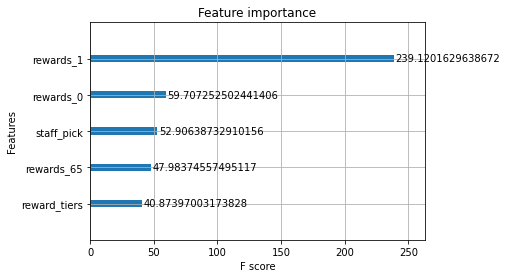

In [26]:
plot_importance(model_xgboost_fin, importance_type = 'gain', max_num_features=5)
plt.show()

In [27]:
var_colums = [c for c in X_train.columns if c not in ['state']]

df_var_imp = pd.DataFrame({"Feature": var_colums,
                           "Importance": model_xgboost_fin.feature_importances_})\
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:10]

,Feature,Importance
7,rewards_1,0.086929
6,rewards_0,0.021706
4,staff_pick,0.019234
71,rewards_65,0.017444
0,reward_tiers,0.014859
421,success_rate,0.013084
11,rewards_5,0.011959
66,rewards_60,0.011470
82,rewards_76,0.011398
3,goal,0.009975


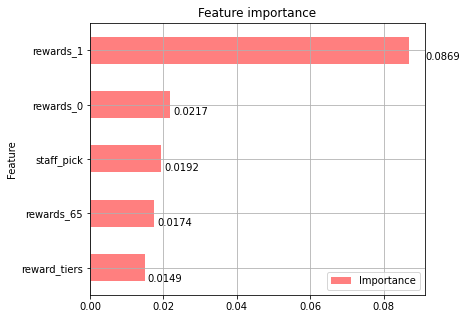

In [30]:
top_5_features = df_var_imp[:5].sort_values('Importance').set_index('Feature')
ax = top_5_features.plot.barh(color='red', alpha=0.5, grid=True, title='Feature importance', figsize=(6, 5))
# df_var_imp[:10].plot(kind='barh',y='Importance',x='Feature',color='r')
for p, value in zip(ax.patches, top_5_features['Importance']):
    ax.annotate(round(value, 4), (p.get_width() * 1.05, p.get_y() * 1.02))